In [17]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
# Pulls the data from our local database 
db_path = '/Users/jinhan.bai/Software/personal/skilltest-zypp/skilltest-buienradar_solutions/database/weather_stream.db'
conn = sqlite3.connect(db_path)
conn.execute("PRAGMA foreign_keys = ON")
print(pd.read_sql("SELECT COUNT(*) AS n FROM stations", conn))
print(pd.read_sql("SELECT COUNT(*) AS n FROM measurements", conn))

df_meas = pd.read_sql(
    """
    SELECT
        *
    FROM measurements m
    """,
    conn
)
df_station = pd.read_sql(
    """
    SELECT DISTINCT
        *
    FROM stations s
    """,
    conn
)
# ik probeer vaak (grote) joins uit te stellen ivm compute, in dit geval is de dataset nog niet zo groot dus is het niet zo een groot probleem
df_joined = pd.merge(df_meas, df_station, on='stationid', how='outer') 
conn.close()


    n
0  39
     n
0  117


In [35]:
# Highest temperature over time on 20 minutes interval
highest_temps = df_meas.loc[df_meas.groupby("timestamp")['temperature'].idxmax()].reset_index(drop=True).copy()
# Join on the stations table to get the station name
highest_temps_with_stations = pd.merge(highest_temps, df_station, on='stationid', how='left')
highest_temps_with_stations

,measurementid,stationid,timestamp,temperature,groundtemperature,feeltemperature,windgusts,windspeedBft,humidity,precipitation,sunpower,stationname,lat,lon,regio
0,6375_2025-09-01T15:50:00,6375,2025-09-01T15:50:00,24.5,27.1,25.8,11.0,4.0,44.0,0.0,675.0,Meetstation Volkel,51.65,5.70,Uden
1,6375_2025-09-01T16:10:00,6375,2025-09-01T16:10:00,24.4,25.1,25.7,9.5,4.0,44.0,0.0,474.0,Meetstation Volkel,51.65,5.70,Uden
2,6370_2025-09-01T16:30:00,6370,2025-09-01T16:30:00,24.9,24.8,25.8,7.9,3.0,39.0,0.0,509.0,Meetstation Eindhoven,51.45,5.42,Eindhoven


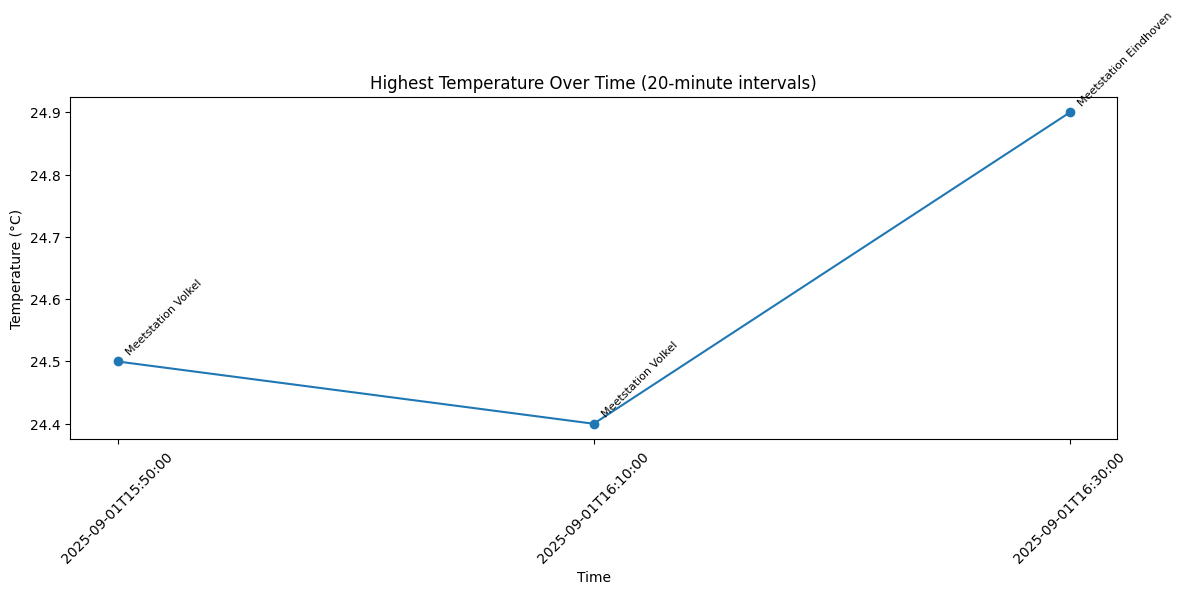

In [36]:
# Plot with highest measured temperature over time
plt.figure(figsize=(12, 6))
plt.plot(highest_temps_with_stations['timestamp'], highest_temps_with_stations['temperature'], marker='o')

# Add station names as annotations
for idx, row in highest_temps_with_stations.iterrows():
    plt.annotate(row['stationname'], 
                (row['timestamp'], row['temperature']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, rotation=45)

plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Highest Temperature Over Time (20-minute intervals)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
# Average measured temperature across all stations over time
avg_temps = df_meas.groupby('timestamp')['temperature'].mean()
avg_temps

timestamp
2025-09-01T15:50:00    21.988235
2025-09-01T16:10:00    22.150000
2025-09-01T16:30:00    22.061765
Name: temperature, dtype: float64

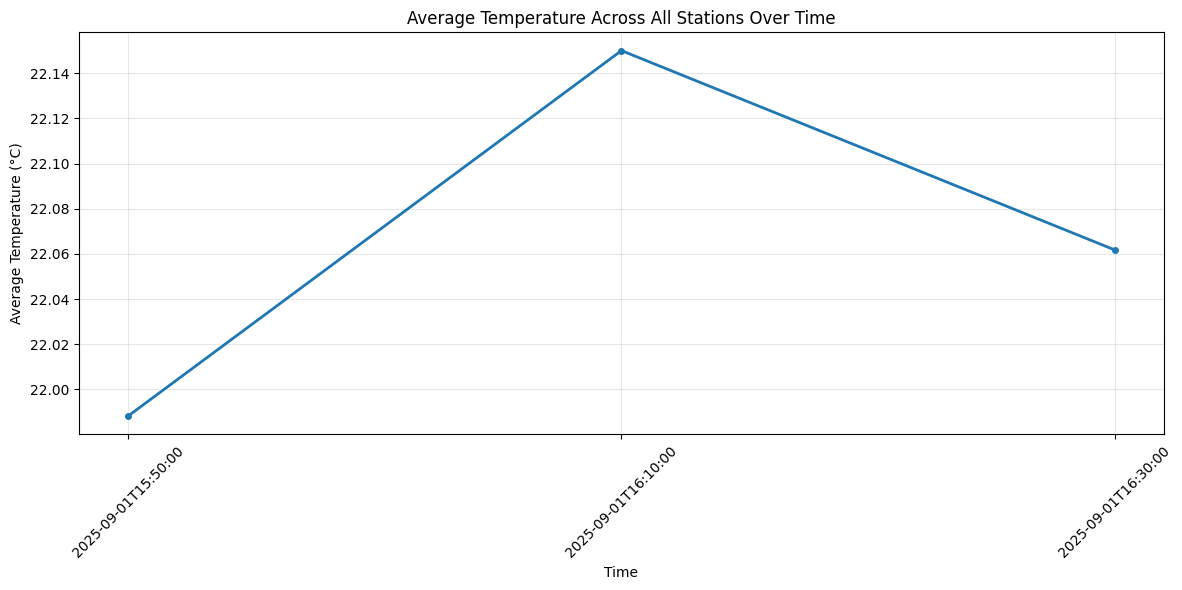

In [38]:
# Plot average measured temperature over time
plt.figure(figsize=(12, 6))
plt.plot(avg_temps.index, avg_temps.values, marker='o', linewidth=2, markersize=4)

plt.xlabel('Time')
plt.ylabel('Average Temperature (°C)')
plt.title('Average Temperature Across All Stations Over Time')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [39]:
# Biggest temperature differences over time
df_meas['temp_diff'] = abs(df_meas['temperature'] - df_meas['feeltemperature'])
high_diff = df_meas.loc[df_meas.groupby("timestamp")['temp_diff'].idxmax()].reset_index(drop=True).copy()
high_diff = pd.merge(high_diff, df_station, on='stationid', how='left')
high_diff

,measurementid,stationid,timestamp,temperature,groundtemperature,feeltemperature,windgusts,windspeedBft,humidity,precipitation,sunpower,temp_diff,stationname,lat,lon,regio
0,6260_2025-09-01T15:50:00,6260,2025-09-01T15:50:00,22.0,23.1,25.2,9.2,3.0,47.0,0.0,202.0,3.2,Meetstation De Bilt,52.10,5.18,Utrecht
1,6348_2025-09-01T16:10:00,6348,2025-09-01T16:10:00,22.3,22.2,25.2,11.6,4.0,50.0,0.0,373.0,2.9,Meetstation Lopik-Cabauw,51.97,4.93,West-Utrecht
2,6310_2025-09-01T16:30:00,6310,2025-09-01T16:30:00,22.1,22.9,25.2,12.1,5.0,49.0,0.0,533.0,3.1,Meetstation Vlissingen,51.45,3.60,Vlissingen


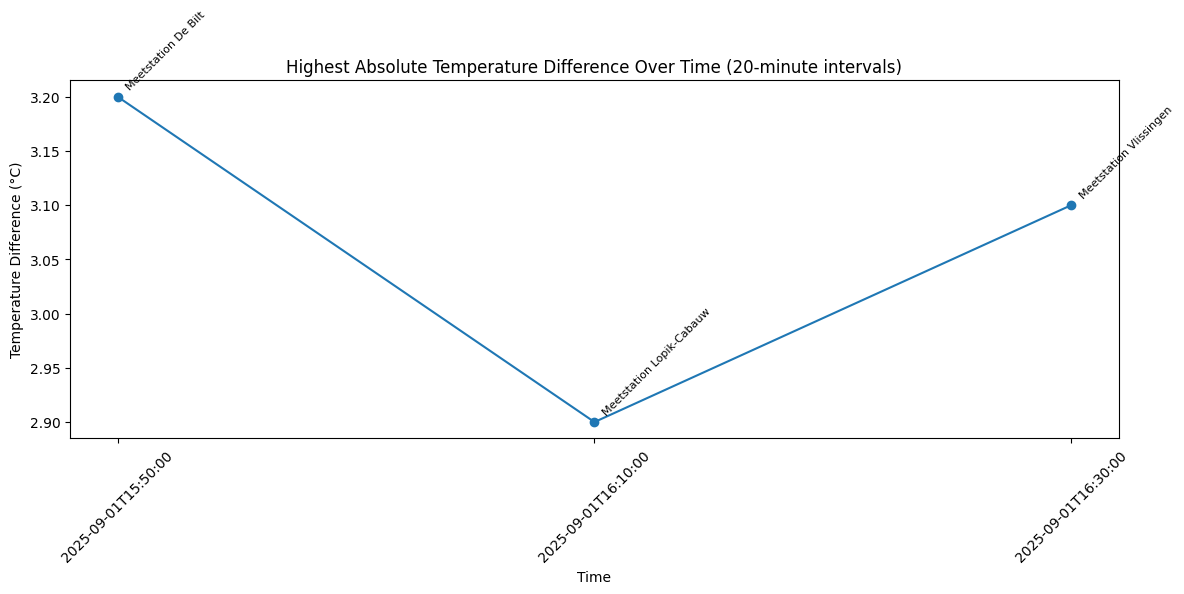

In [40]:
# Plot with highest absolute temperature differences over time
plt.figure(figsize=(12, 6))
plt.plot(high_diff['timestamp'], high_diff['temp_diff'], marker='o')

# Add station names as annotations
for idx, row in high_diff.iterrows():
    plt.annotate(row['stationname'], 
                (row['timestamp'], row['temp_diff']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, rotation=45)

plt.xlabel('Time')
plt.ylabel('Temperature Difference (°C)')
plt.title('Highest Absolute Temperature Difference Over Time (20-minute intervals)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()